# Introduction to K-Means Clustering

## Background
We have up until now been focussed on regression and classification, the two major areas of statistical learning which make up what we call supervised learning. The defining characteristic of supervised learning is that all the observations in the data set are labelled. 'Labelled' means that each observation has an output value which we could use to train a predictive regression model, or has been allocated a class which we could use to train a classification model.

Unsupervised learning is an area of statistical learning which we use to infer trends and extract patterns and groupings from unlabelled data. A variety of methods to carry out unsupervised learning are available to us, one of which is known as clustering. Clustering methods use features of the data to group observations into either distinct or overlapping sets.


## The K-Means Clustering Algorithm
K-Means is what is known as a hard-clustering method, which means that the clusters, or groups, that result are distinct and non-overlapping. In other words, each observation will ultimately belong to only one cluster, although it may be passed around between clusters during the iterative clustering process.

The k in k-means refers to the number of clusters, and this number needs to be specified beforehand by the analyst. This is seen as one of the drawbacks of the k-means method, because clustering is often used to uncover groupings that are not necessarily obvious to the analyst. We do, however, have methods available to us which we can use to determine an optimal number of clusters using common statistical methods. This method will be covered later on, but for now let's take a look at the k-means algorithm, which takes place after we have specifed a number of clusters, k.

1. Randomly assign each observation a cluster number from 1 to k
2. Repeat the following until cluster assignments stop changing:  
    a. For each of the k clusters, compute the cluster centroid. The $k^{th}$ cluster centroid is the mean of the observations in the $k^{th}$ cluster.  
    b. Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance).
    
The sequence of images below illustrates the k-means algorithm as it iterates over a data set.
<img src="https://docs.google.com/uc?export=download&id=1uORME9EgXhbv39YAFaisk-1TpaIXX66l" width="500">

Source: [Introduction to Statistical Learning by Trevor Hastie and Rob Tibshirani](https://www-bcf.usc.edu/~gareth/ISL/)

### How many clusters do we need?
We can now revisit the topic of having to specify a number of clusters, k, when making use of the k-means method. We will make use of a popular technique called the **'Elbow Method'** for determining how many clusters to choose.   

To use the elbow method, we will perform k-means clustering a number of times, changing the value of k each time. For each value of k, we will measure the *total within-cluster sum of squares*, or *WCSS*.   

<img src="https://github.com/jordanExplore/Explore_resources/blob/master/wcss.PNG?raw=true" width="700">

WCSS is a measure of the similarity of the observations within our clusters. Lower WCSS means that a cluster is more tightly grouped. Naturally, as we increase k, WCSS will decrease until k is equal to the number of data points in our data set (when WCSS will be zero). But what use is having as many clusters as there are observations? We need to find the optimal number of clusters such that each cluster is sufficiently consistent in its attributes without having too many clusters.   

![alt text](https://github.com/jordanExplore/Explore_resources/blob/master/wcss2.PNG?raw=true)

With that theory out of the way, let's attempt to apply the k-means clustering method to some actual data. We will be using the same data set of US census information from 2015 that was used in the previous tutorial on principal component analysis.

In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# clustering
from sklearn.cluster import KMeans
from time import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
us_df = pd.read_csv('acs2015_county_data.csv', encoding='UTF-8').dropna()

In [3]:
# check that each column has the same number of values
us_df.count()

CensusId           3218
State              3218
County             3218
TotalPop           3218
Men                3218
Women              3218
Hispanic           3218
White              3218
Black              3218
Native             3218
Asian              3218
Pacific            3218
Citizen            3218
Income             3218
IncomeErr          3218
IncomePerCap       3218
IncomePerCapErr    3218
Poverty            3218
ChildPoverty       3218
Professional       3218
Service            3218
Office             3218
Construction       3218
Production         3218
Drive              3218
Carpool            3218
Transit            3218
Walk               3218
OtherTransp        3218
WorkAtHome         3218
MeanCommute        3218
Employed           3218
PrivateWork        3218
PublicWork         3218
SelfEmployed       3218
FamilyWork         3218
Unemployment       3218
dtype: int64

In [4]:
# what does the data look like?
us_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [5]:
# create short list of unwanted columns
labels = ['CensusId', 'State', 'County']

# declare the features to be all columns, less the unwanted ones from above
features = [col for col in us_df.columns if col not in labels]

With clustering, we can never be sure how many clusters we will get, and what information they will be clustered on! Looking at the data, my intuition says that we could expect some grouping based loosely on income groups and on race groups. As there are four race groups, it might be fair to hypothesize that 4 clusters based on race groups might result, possibly where each cluster represents a group with one race more prominent than any of the others.

Let's be sure to scale the data first, since the k-means algorithm makes use of a distance metric and we have many variables with different scales of measurement.

In [6]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
us_df_scaled = pd.read_csv('acs2015_county_data.csv', encoding="UTF-8").dropna()
us_df_scaled[features] = preprocessing.scale(us_df_scaled[features])

C:\Users\jlesl\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


### Deciding on Number of Clusters, k
Take a look at the loop below.

We have chosen a range of values for k between 1 and 20. For each value of k, we will run the k-means clustering algorithm and record the WCSS (referred to as **`inertia_`** in sklearn).

Have a look at the docstring of the **`KMeans`** function to find out what the **`n_init`** and **`max_iter`** arguments do.

In [7]:
# let's try everything between 1 and 20 clusters
n_clusters = np.arange(1, 21)

In [8]:
# store errors for each value of k
errors = []

# for i between 1 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(us_df_scaled[features])
    # measure WCSS
    errors.append(km.inertia_)

Now that we have performed k-means clustering for each value of k between 1 and 20, we need to create a plot showing the WCSS for each corresponding value of k.

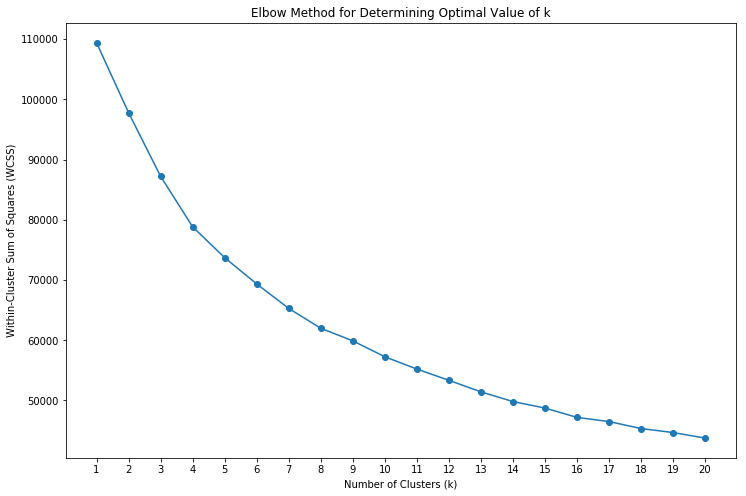

In [9]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

The elbow method is as simple as observing the plot of the within-cluster sum of squares (WCSS) for each number of clusters and deciding where the 'elbow' is. The elbow is loosely defined as the point at which the WCSS curve has its greatest decrease in slope. In other words, it is the point after which adding another cluster does not meaningfully decrease the WCSS.

Below, we have provided a duplicate of the code used to generate the elbow plot from above. The 2nd last line of code is incomplete - set the `x=` argument in the `plt.axvline()` function to draw a vertical line at the number of clusters you think the elbow occurs at.

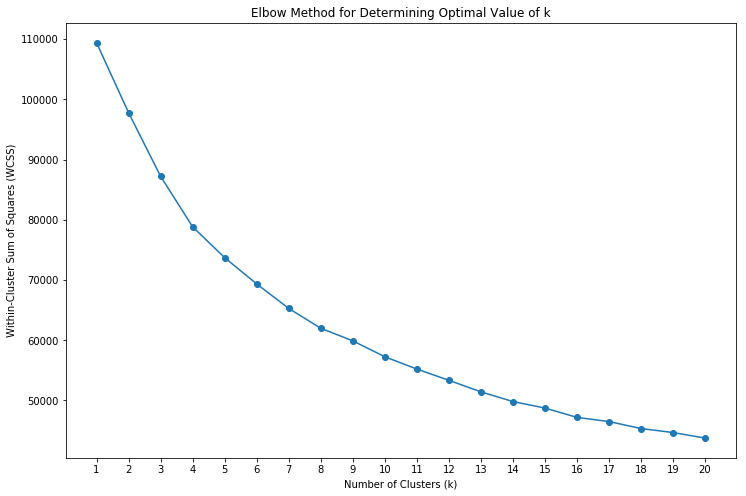

In [12]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)

# SET THE X-VALUE BELOW TO THE NUMBER OF CLUSTERS
# AT WHICH THE ELBOW OCCURS
plt.axvline(x= , color='r', lw=2)
plt.show()

# run this code block by hitting Shift+Enter

This is a tricky elbow plot to decipher, but we thought there was a slight kink at k=4 - this is where you should have plotted your vertical line. We will now cluster our observations using k=4.

In [15]:
# remember to set the random state for reproducibility
km = KMeans(n_clusters=4, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(us_df_scaled[features])
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 0.582s


In [16]:
# let's take a glimpse at the first 100 observations to see
# which clusters they have been allocated to
km.labels_[:100]

array([3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3,
       3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1,
       3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1])

In [17]:
# add cluster labels 1, 2 and 3
us_df['km_cluster'] = km.labels_ + 1

Let's take a look at the median values for each feature of each of the four clusters.

In [18]:
# it's a little easier to read when we transpose the result, so that each column is a cluster
us_df.groupby('km_cluster').agg('median').T

km_cluster,1,2,3,4
CensusId,26125.0,28139.00,31127.0,29120.0
TotalPop,862215.0,21362.00,4583.0,36494.5
Men,423260.0,10553.50,2389.0,18155.0
Women,438998.0,10835.50,2229.0,18184.0
Hispanic,16.1,4.50,3.8,3.4
White,55.4,53.40,88.8,88.7
Black,10.9,21.60,0.3,1.9
Native,0.2,0.20,0.6,0.2
Asian,6.0,0.30,0.3,0.6
Pacific,0.0,0.00,0.0,0.0


Skimming through the columns and rows above, there are certainly some features that are being clustered on. That is to say, there are obvious differences or discrepancies between values for certain features across the four clusters.

For instance, the median value of `TotalPop` in cluster 1 is nearly 900,000, but as low as 4,000 in cluster 3. What this means is that the k-means method has grouped observations according to their relative `TotalPop` values. Perhaps cluster 1 is a grouping of the counties containing the larger cities, like New York City, Los Angeles, Atlanta, Chicago, etc.

By contrast, take a look at the features of `Male` and `Female`. As we would expect, these values are very close to half of the `TotalPop` value for each cluster, so we could say there is no clustering being done on these two features.

Another notable feature here is that of `IncomePerCap`. While clusters 3 and 4 are fairly similar, between 24,000 and 26,000, cluster 2 is considerably lower at just over 18,000. Cluster 1 is by far the highest at 33,000. We might then infer that cluster 2 was a grouping of the poorer counties, and cluster 1 a grouping of the wealthier ones. This ties in with our suggestion that Cluster 1 contains the large cities, as we would expect higher paying jobs to be found in bigger cities like New York.

Lastly, one other worthy mention is that of `ChildPoverty`. We can see that cluster 2 has by far the highest child poverty value. Again, this ties in with our suggestions that cluster 2 contains poorer, smaller counties.

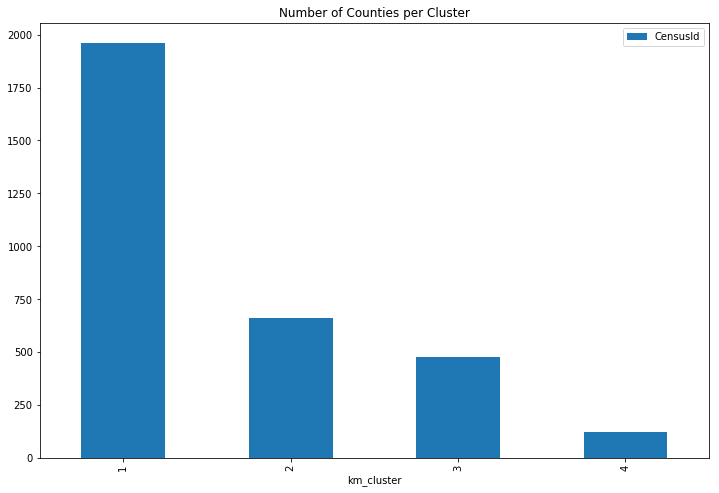

In [14]:
us_df[['CensusId', 'km_cluster']].groupby(
    'km_cluster').count().reset_index().plot(kind='bar', 
                                              x='km_cluster', 
                                              figsize=(12,8), 
                                              title='Number of Counties per Cluster')
plt.show()

Above, we've plotted the number of counties per cluster, and we see that the fewest number of counties is in cluster 1. Again, this makes sense - we would expect that there are far fewer big, wealthy cities than small ones.